## TinyTol diffractive pupil design

In [1]:
import morphine
import numpy

import jax
import jax.numpy as np
from jax import jit, vmap, grad

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from funcs import *

In [2]:
# We used jax version 0.1.75
jax.version.__version__

'0.1.75'

## Set constants

In [3]:
N = 250 # number of modes
PPSZ = 256 # Number of pixels
PSZ = PPSZ*3 # For every 'pixel', represent as 3x3 pixels so thet gradients can be calculated
WAVELENGTH = 1.0e-6 # nm

## Support

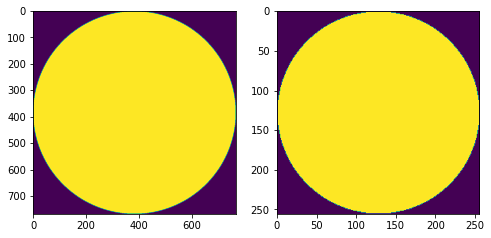

In [4]:
support = morphine.zernike.zernike_basis(1,npix = PSZ, outside = 0.0)[0,:,:]
small_support = morphine.zernike.zernike_basis(1,npix = PPSZ, outside = 0.0)[0,:,:]
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1); plt.imshow(support); 
plt.subplot(1, 2, 2); plt.imshow(small_support); 
plt.show()

## Define constraints

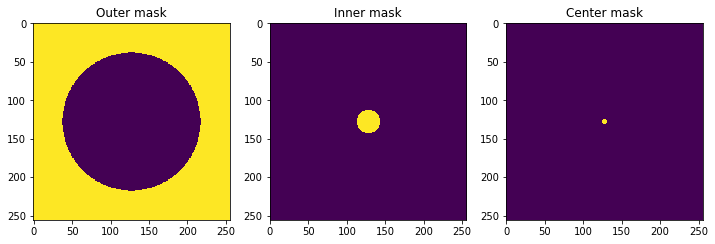

In [5]:
r = radius_meshgrid(PPSZ)

outer_mask = -((r<(90*2/PPSZ))-1)
inner_mask = -((r>(10*3/PPSZ))-1)
center_mask = -((r>(2*3/PPSZ))-1)

plt.figure(figsize = (12, 4))
plt.subplot(1, 3, 1); plt.imshow(outer_mask, interpolation = 'none'); plt.title('Outer mask')
plt.subplot(1, 3, 2); plt.imshow(inner_mask, interpolation = 'none'); plt.title('Inner mask')
plt.subplot(1, 3, 3); plt.imshow(center_mask, interpolation = 'none'); plt.title('Center mask')
plt.show()

## Set central phase to 0

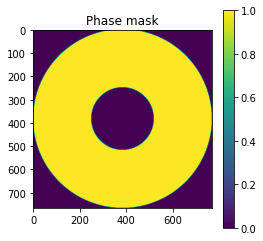

In [6]:
r = radius_meshgrid(PSZ)
phase_mask = (r < 1)*(r > 0.35)

plt.figure(figsize = (4, 4))
plt.imshow(phase_mask); plt.title("Phase mask"); plt.colorbar()
plt.show()

## Load basis

In [7]:
basis1 = np.load('./tinytol_basis_1.npy')
basis2 = np.load('./tinytol_basis_2.npy')
basis3 = np.load('./tinytol_basis_3.npy')
basis4 = np.load('./tinytol_basis_4.npy')
basis = np.hstack((basis1, basis2, basis3, basis4))

## Run gradient descent

In [8]:
@jit
def objective_function(coeffs, basis, phase_mask, small_support, outer_mask, inner_mask, center_mask):
    wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)
    wf *= phase_mask
    binary = soft_binarise_wf(wf)
    psf, _ = get_psf(binary, small_support)
    
    peak = np.max(psf)                  # reduce the maximum peak
    outer = np.sum(outer_mask * psf)    # reduce anything outside the disk
    inner = np.max(inner_mask * psf)    # reduce anything outside the disk
    center = np.sum(center_mask * psf)  # reduce anything outside the disk
    ge = calc_ge(psf, rmax = 90)        # maximise this
    ftwge = calc_ftrwge(psf, rmax = 90) # maximise this
    
    obj_func = 15*np.max([outer, 0.0573]) + 5e3*np.max([inner, 5e-5]) + 1e3*np.max([center, 0.000548]) + 1e4*np.max([peak, 0.00012]) - 1e5 * ge - 50 * ftwge
    return obj_func

In [9]:
results = []
seeds = [11, 24, 26, 27]
for seed in seeds:

    numpy.random.seed(seed)
    coeffs = numpy.random.rand(N)

    epochs = 250; lr = 0.05
    grad_obj = (grad(objective_function))

    for i in range(epochs):     
        coeffs -= lr*grad_obj(coeffs, basis, phase_mask, small_support, outer_mask, inner_mask, center_mask)
    results.append(coeffs)


In [10]:
results = np.array(results)
with open('tinytol_paper.npy', 'wb') as f:
    np.save(f, results)

## Results

In [11]:
results = np.load('tinytol_paper.npy')

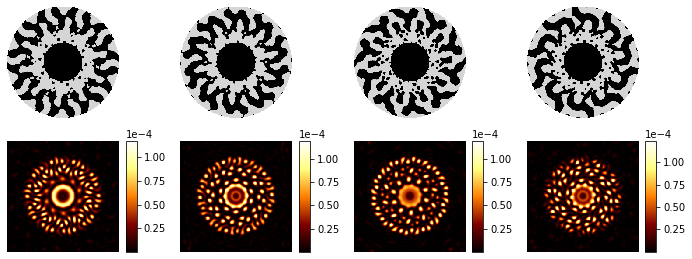

In [14]:
cmap = mpl.cm.binary; cmap.set_bad(color = '#FFFFFF')

plt.figure(figsize = (15, 4.5))
for i in range(4):
    coeffs = results[i]
    wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)
    wf *= phase_mask
    binary = soft_binarise_wf(wf)
    psf, _ = get_psf(binary, small_support)
    
    binary = jax.ops.index_update(binary, small_support < 0.5, np.nan)

    plt.subplot(2, 5, i+1);
    plt.imshow(((binary -1) * 2 * np.pi), interpolation = 'none', cmap = 'gray', vmin = -np.pi, vmax = 0.2*np.pi)
    plt.axis('off')
    cb = plt.colorbar(aspect = 10); cb.remove()
    
    plt.subplot(2, 5, i + 6); plt.imshow(psf, interpolation = 'none', cmap = 'afmhot'); plt.axis('off')
    cb = plt.colorbar(aspect = 10); cb.formatter.set_powerlimits((0, 0)); cb.ax.yaxis.set_offset_position('left')
plt.savefig('./tinytol_samples.pdf', bbox_inches='tight', pad_inches=0.15)